In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn import preprocessing
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matlab.engine
from concurrent.futures import ThreadPoolExecutor

from concurrent.futures import as_completed
import pandas as pd
import os.path
from shutil import copyfile
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix
from data import datasetManager,baseDataSet, create_lines
import configuration
from nets import *

In [2]:
def test_batch(net,data_manager,amount = 8):
    results,delays,orig_patterns = data_manager.create_batch(net,amount)
    images = data_manager.create_pressure_batch(delays)
    x = np.linspace(-15e-3,15e-3,configuration.IMG_X)

    z = np.linspace(10e-3,80e-3,300)
    if amount == 4:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))
        ax2.plot(x *1e3,results[0,:])
        ax2.set_title('result from net')
        ax1.plot(x *1e3,orig_patterns[0,:])
        ax1.set_title('expected')
        ax3.imshow(np.rot90(images[0,:,:],4),cmap = 'hot',extent = [-15,15,80,10])
    else:
        for i in range(amount):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
            ax2.plot(x *1e3,results[i,:])
            ax2.set_title('result from net')
            ax1.plot(x *1e3,orig_patterns[i,:])
            ax1.set_title('expected')
            ax3.imshow(np.rot90(images[i,:,:],4),cmap = 'hot',extent = [-15,15,80,10])


In [3]:
dataManager = datasetManager(csv_file = configuration.path_gs,orig = configuration.path_gs_orig)

In [4]:
train = dataManager.get_datasets()[0]
print(train[0])
print(train[15][1] - train[0][1])
print(torch.sum(train[19][0]))
print(train[15][1].size())

(tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64), tensor([0.0016, 0.0016, 0.0016,  ..., 0.0015, 0.0015, 0.0015],
       dtype=torch.float64))
tensor([0.1069, 0.1067, 0.1064,  ..., 0.1077, 0.1074, 0.1072],
       dtype=torch.float64)
tensor(2., dtype=torch.float64)
torch.Size([1024])


In [5]:
def fsp_x_near(source,dz = configuration.depth):
    new_source = torch.zeros(source.size()[0],configuration.IMG_X) 
    new_source[:,int(configuration.IMG_X/2) - int(source.size()[1]/2):int(configuration.IMG_X/2) + int(source.size()[1]/2)] = source
    FFT_inp = torch.fft.fftshift(torch.fft.fft(torch.fft.fftshift(new_source)))
    du=1/configuration.pitch/configuration.IMG_X
    xx = torch.arange(-int(configuration.IMG_X/2),int(configuration.IMG_X/2))
    PS=torch.exp(torch.tensor(1j)*2*np.pi*dz/configuration.Wavelength*(torch.sqrt(1-torch.pow((xx*du*configuration.Wavelength),2))))
    new_source = torch.fft.ifftshift(torch.fft.ifft(torch.fft.ifftshift(PS * FFT_inp)))
    return new_source.abs() ** 2

In [6]:
def loss_gs(source,target,base_loss = nn.MSELoss()):
    new_source = fsp_x_near(source)
    if configuration.device == 'cpu':
        #MSE
        loss = torch.mean((new_source - target) ** 2)
    else:
        loss = base_loss(new_source,target)
    return loss

    

In [7]:
def test_batch_delays(net,data_manager,amount = 8):
    datasets = dataManager.get_datasets()
    test = DataLoader(datasets[2],batch_size = configuration.batch_size, shuffle = True, drop_last = True)
    patterns = torch.zeros((amount,configuration.IMG_X))
    ground = torch.zeros((amount,256))
    delays = np.zeros((amount,256))
    res = np.zeros((amount,configuration.IMG_X))
    width = 0.218e-3 * 128
    delay_x = np.linspace(-width/2,width/2,128)
    x_line = np.linspace(-15e-3,15e-3,configuration.IMG_X)
    z = np.linspace(10e-3,80e-3,300)
    seq_length = configuration.SEQ_LENGTH

    i = 0

    for x,y in test:
        if i >= amount:
            break
        amount_added = x.size(0)
        seq_length = x.size(2)
        if i + amount_added > amount:
            x = x[:amount - i]
            y = y[:amount - i] 
            amount_added = amount - i
        net.eval()
        patterns[i:i+amount_added,:] = x.reshape(-1,configuration.IMG_X)
        ground[i:i+amount_added,:] = y
        i += amount_added        
    if isinstance(net,lstmModel):
        h = net.init_hidden(amount)
        to_send = patterns.reshape((amount,-1,seq_length))
        delays, h  = net(to_send.float(),h)
    else:
            #patterns_to_send = patterns.reshape(amount,-1,self.seq_length)
        delays = net(patterns.float())
    delays[:,:128] *= 1e-5
    with ThreadPoolExecutor() as executor:
        new_delay = torch.reshape(delays,(len(data_manager.eng),-1))
        results = executor.map(create_lines,data_manager.eng,new_delay)
    size_eng = amount / len(data_manager.eng)
    for i,line in enumerate(results):
        res[round(size_eng * i):round(size_eng *(i+1)),:] = line
    images = data_manager.create_pressure_batch(delays)
    delays[:,:128] *= 1e5
    for i in range(amount):
        fig, (ax1, ax2, ax3,ax4) = plt.subplots(1, 4, figsize = (15,5))
        ax1.plot(x_line *1e3,res[i,:], label = 'from net')
        ax1.plot(x_line *1e3,patterns.cpu().detach().numpy()[i,:], label = 'ground')
        ax1.set_title('at image plane')
        ax1.legend()
        ax3.imshow(np.rot90(images[i,:,:],4),cmap = 'hot',extent = [-15,15,80,10])
        ax2.plot(delay_x,delays.cpu().detach().numpy()[i,:128], label = 'from net')
        ax2.plot(delay_x,ground.cpu().detach().numpy()[i,:128], label = 'ground')
        ax2.set_title('delays')
        ax2.legend()
        ax4.plot(delay_x,delays.cpu().detach().numpy()[i,128:], label = 'from net')
        ax4.plot(delay_x,ground.cpu().detach().numpy()[i,128:], label = 'ground')
        ax4.set_title('amplitudes')
        ax4.legend()


In [8]:
def display_eval(net,data_set,amount = 4):
#    x,y = data_set[:amount]
    pitch_half = configuration.pitch/2
    x_half = np.arange(-(configuration.IMG_X-1) *pitch_half/2,configuration.IMG_X * pitch_half/2,pitch_half)
    im = torch.zeros(amount,configuration.IMG_Y,configuration.IMG_X)
    with torch.no_grad():
        net.eval()
        x = torch.zeros(amount,configuration.IMG_X)
        y = torch.zeros(amount,configuration.IMG_X)
        for i in range(amount):
            ele = np.random.randint(0,len(data_set))
            x[i,:], y[i,:] = data_set[ele]
        x.to(configuration.device),y.to(configuration.device)
        output = net(x.float())
        z = torch.linspace(0,80e-3,configuration.IMG_Y)
        for i in range(amount):
            for j in range(configuration.IMG_Y):
                im[:,j,:] = fsp_x_near(output,z[j]).abs()
        at_target = fsp_x_near(output)
        x = x.detach().abs().numpy()
        y = y.detach().abs().numpy() ** 2
        at_target = at_target.detach().abs().numpy() ** 2
        im = im.detach().abs().numpy()
        for i in range(amount):
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15,5))
            ax1.plot(x_half,x[i,:])
            ax1.set_title('base pattern')
            ax2.plot(x_half,y[i,:])
            ax2.set_title('from GS')
            ax3.plot(x_half,at_target[i,:])
            ax3.set_title('from net')
            ax4.imshow(im[i,:,:])

    

In [9]:
def trainLstm(net,opt,dataManager,schedular,n_epochs = 30,batch_size = 40, criterion = nn.MSELoss()):
    datasets = dataManager.get_datasets()
    train = DataLoader(datasets[0],batch_size = batch_size, shuffle = True, drop_last = True)
    val = DataLoader(datasets[1],batch_size = batch_size, shuffle = True, drop_last = True)
    test = DataLoader(datasets[2],batch_size = batch_size, shuffle = True, drop_last = True)
    net.to(configuration.device)
    train_loss_total = []
    val_loss_total = []
    test_loss_total = []
    #criterion = nn.L1Loss() #will probably have outliers, L1 is more robust
    #criterion = nn.MSELoss()
    #criterion = nn.CosineSimilarity()
    for i in range(n_epochs):
        training_loss = 0
        val_loss = 0
        net.train()
        h = net.init_hidden(batch_size)
        for x,y in train:
            h = tuple([e.data for e in h])
            x.to(configuration.device),y.to(configuration.device)
            print(x.shape())
            opt.zero_grad()
            output, h  = net(x.float(),h)
            loss = criterion(output,y)
            loss.backward()
            training_loss += loss.item()
            nn.utils.clip_grad_norm_(net.parameters(), 1) 
            opt.step()
        with torch.no_grad():
            net.eval()
            h = net.init_hidden(batch_size)
            for x,y in val:
                h = tuple([e.data for e in h])
                x.to(configuration.device),y.to(configuration.device)
                output, h  = net(x.float(),h)
                loss = criterion(output,y)
                val_loss += loss.item()
        training_loss = training_loss / len(train)
        if len(val) == 0:
            val_loss = 'no values'
        else:
            val_loss = val_loss / len(val)
        print(f'epoch num: {i}, train loss: {training_loss}, validation loss:{val_loss}, length of train {len(train) * batch_size}')
        schedular.step()
        if i % 3 == 0:
            print(f'testing at epoch num: {i}')
            display_eval(net,eval_set)
       
           
            #test_batch_delays(net,dataManager)
            #test_batch(net,dataManager)
            # for name, param in net.named_parameters():
            #     if param.requires_grad:
            #         print (name, torch.mean(param.data))
        #results,delays,orig_patterns = dataManager.create_batch(net,amount = 500)
        #dataManager.add_batch_to_data(torch.cat((results,delays),1), mode = 'add')



'cuda'

In [10]:
def trainModel(net,opt,dataManager,schedular,n_epochs = 30,batch_size = 20, criterion = nn.MSELoss()):
    datasets = dataManager.get_datasets()
    eval_set = datasets[1]
    train = DataLoader(datasets[0],batch_size = batch_size, shuffle = True, drop_last = True)
    val = DataLoader(datasets[1],batch_size = batch_size, shuffle = True, drop_last = True)
    test = DataLoader(datasets[2],batch_size = batch_size, shuffle = True, drop_last = True)
    net.to(configuration.device)
    train_loss_total = []
    val_loss_total = []
    test_loss_total = []
    #criterion = nn.MSELoss()
    #criterion = nn.L1Loss() #will probably have outliers, L1 is more robust
    #criterion = nn.CosineSimilarity()
    for i in range(n_epochs):
        training_loss = 0
        val_loss = 0
        net.train()
        for x,y in train:
            x.to(configuration.device),y.to(configuration.device)
            opt.zero_grad()
            output = net(x.float())
            loss = criterion(output,y.float())
            loss.backward()
            training_loss += abs(loss.item())
            nn.utils.clip_grad_norm_(net.parameters(), 1)
            opt.step()
        with torch.no_grad():
            net.eval()
            for x,y in val:
                x.to(configuration.device),y.to(configuration.device)
                output = net(x.float())
                loss = criterion(output,y)
                val_loss += abs(loss.mean().item())
        training_loss = training_loss / len(train)
        if len(val) == 0:
            val_loss = 'no values'
        else:
            val_loss = val_loss / len(val)
        
        print(f'epoch num: {i}, train loss: {training_loss}, validation loss:{val_loss}, length of train {len(train) * batch_size}')
        schedular.step()
        if i % 3 == 0:
            print(f'testing at epoch num {i}')
            display_eval(net,eval_set)
#            print(f'testing at epoch num: {i}')
#            test_batch_delays(net,dataManager)
#            test_batch(net,dataManager)
            # for name, param in net.named_parameters():
            #     if param.requires_grad:
            #         print (name, torch.mean(param.data))
#        results,delays,orig_patterns = dataManager.create_batch(net,amount = 500)
#        dataManager.add_batch_to_data(torch.cat((results,delays),1), mode = 'add')
 #       dataManager.generate_base_dataset(mode = 'add')
#        if i%3 == 0:
#            print(f'testing iteration number: {i}')
#            test_batch(net,dataManager,amount = 4)



In [11]:


dataManager.reset()
# dataManager.get_datasets()[0].test_get(10)
#dataManager.generate_base_dataset()
#dataManager.generate_base_dataset(mode = 'add')
#dataManager.generate_base_dataset(mode = 'add')
#dataManager.generate_base_dataset(mode = 'add')
#dataManager.generate_base_dataset(mode = 'add')



In [12]:
a = dataManager.get_datasets()[1]
print(type(a.data.iloc[1,0]))

<class 'numpy.int64'>


In [13]:
net = cnn_model(drop = 0.6)

optimizer = optim.Adam(net.parameters(),lr = 0.001, weight_decay = 1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
loss = loss_gs
trainModel(net,optimizer,dataManager,scheduler,n_epochs = 10, criterion= loss)
#test_batch_delays(net,dataManager)
#test_batch(net,dataManager) 



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper__native_batch_norm)

In [19]:
net = lstmModel(n_layers = 2, drop = 0.4)
optimizer = optim.SGD(net.parameters(),lr = 0.01, momentum = 0.95, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
#dataManager.reset()
trainLstm(net,optimizer,dataManager,scheduler,n_epochs = 10)
#test_batch_delays(net,dataManager)
#test_batch(net,dataManager)


TypeError: 'torch.Size' object is not callable

In [8]:
with open(configuration.path_gs,'r+') as f:
    data = f.read()
    data = data.replace('i','j')
    f.seek(0)
    f.write(data)
with open(configuration.path_gs_orig,'r+') as f:
    data = f.read()
    data = data.replace('i','j')
    f.seek(0)
    f.write(data)

In [ ]:
net = lstmModel(n_layers = 2, drop = 0.8)
optimizer = optim.SGD(net.parameters(),lr = 0.1, momentum = 0.95, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.75)
dataManager.reset()
trainLstm(net,optimizer,dataManager,scheduler,n_epochs = 20)
test_batch_delays(net,dataManager)
test_batch(net,dataManager)


TypeError: new() received an invalid combination of arguments - got (float, int), but expected one of:
 * (*, torch.device device)
      didn't match because some of the arguments have invalid types: (!float!, !int!)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [ ]:
print(net.fc1[0].weight,net.fc1[0].bias)



In [ ]:
net = basic_model(drop = 0.6)
print('trying to create new batch')
results,delays,orig_patterns = dataManager.create_batch(net)
print('created new batch, trying to add to data')
dataManager.add_batch_to_data(torch.cat((results,delays),1))



20


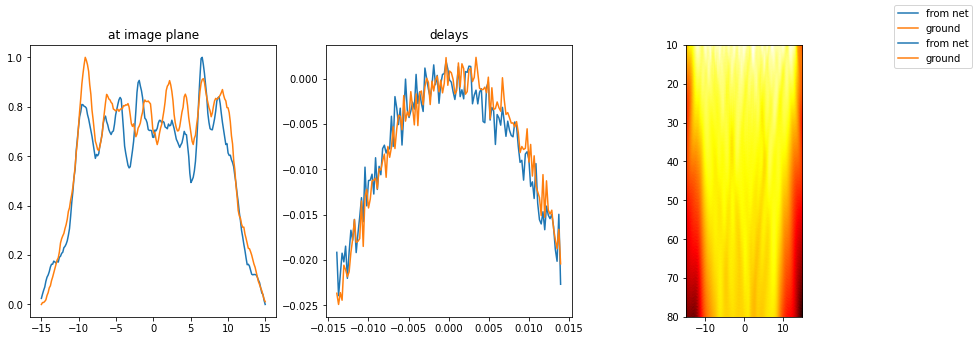

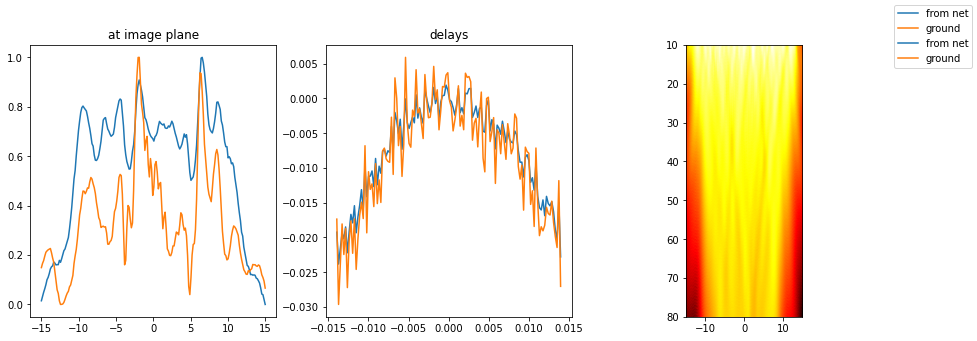

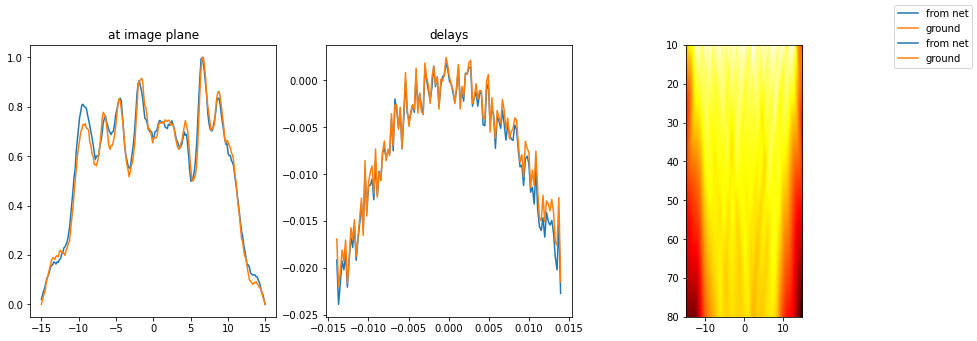

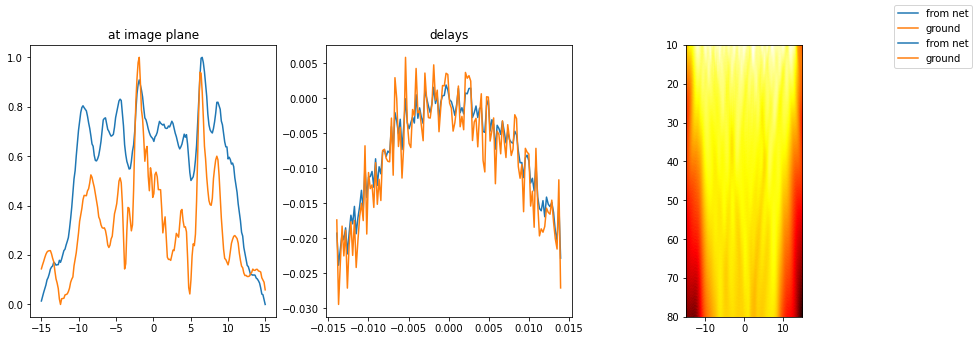

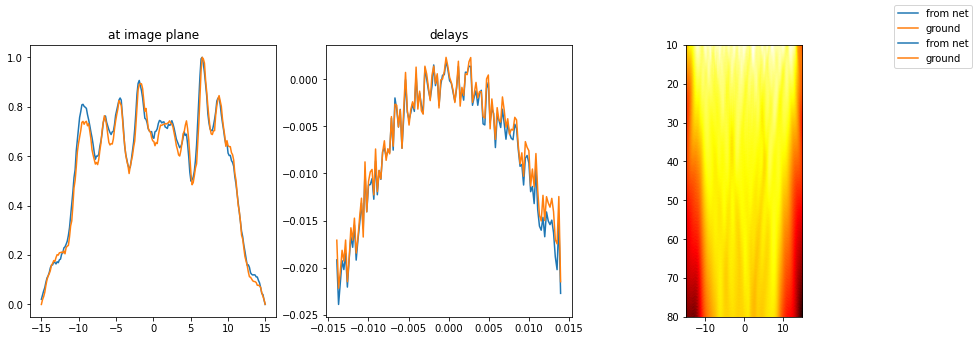

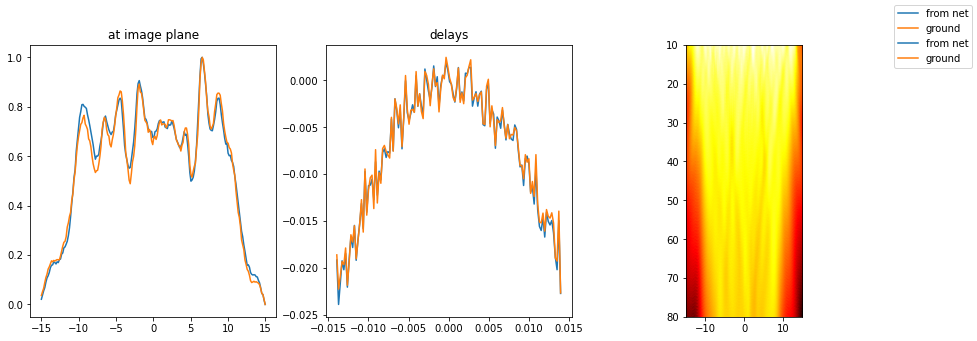

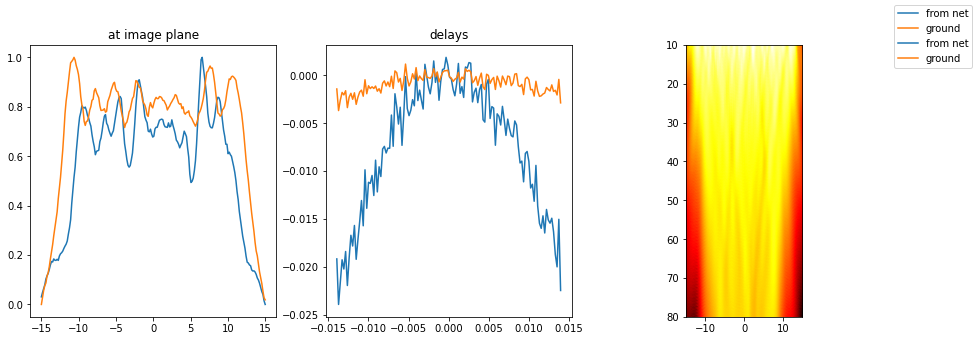

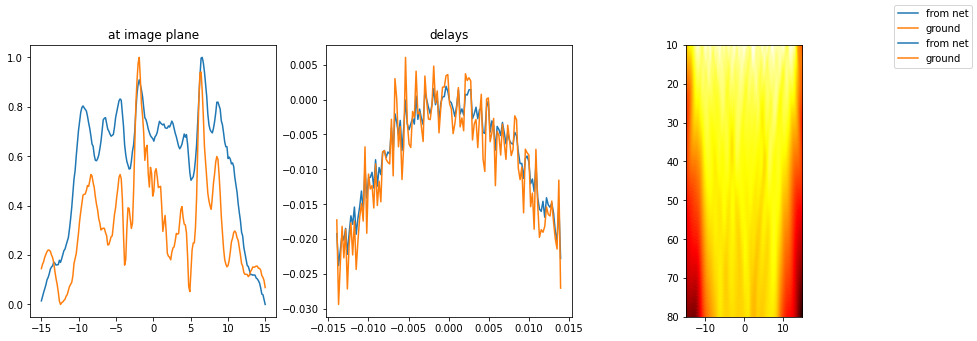

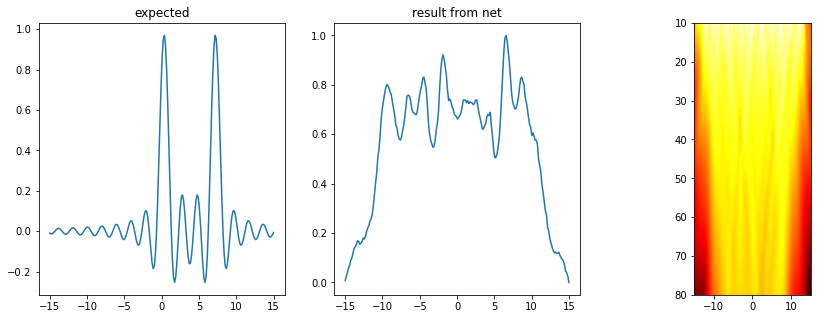

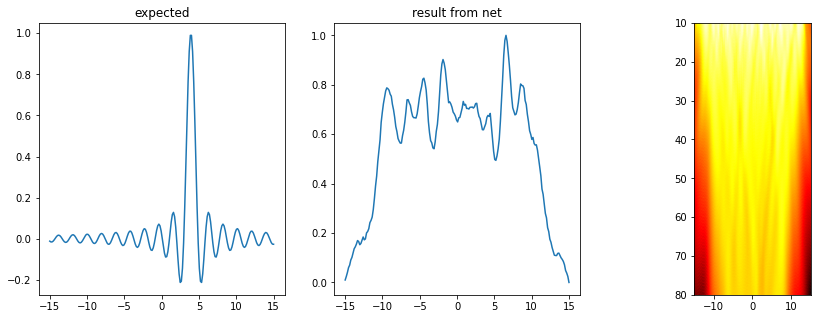

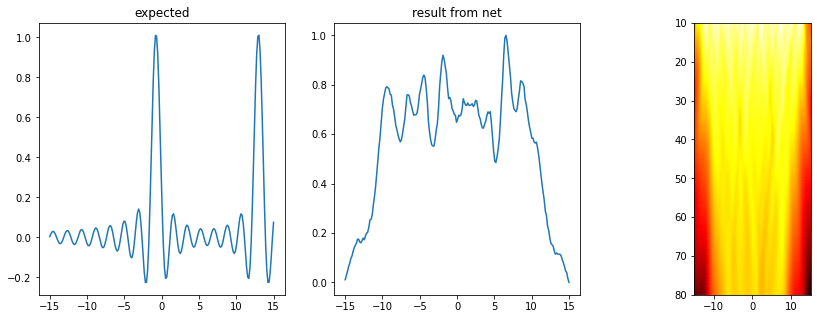

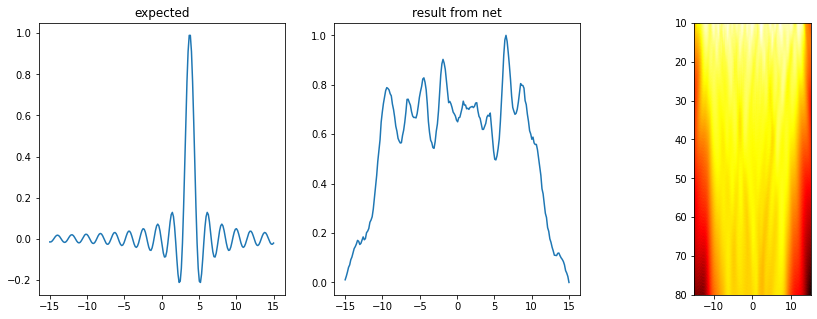

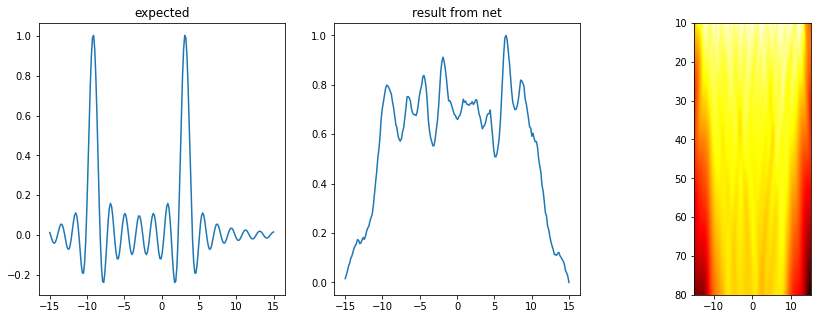

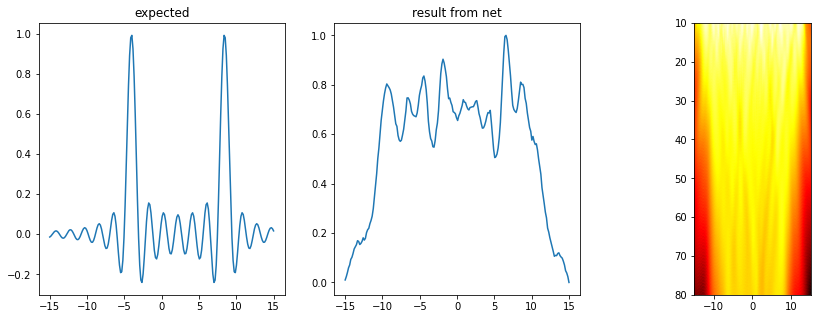

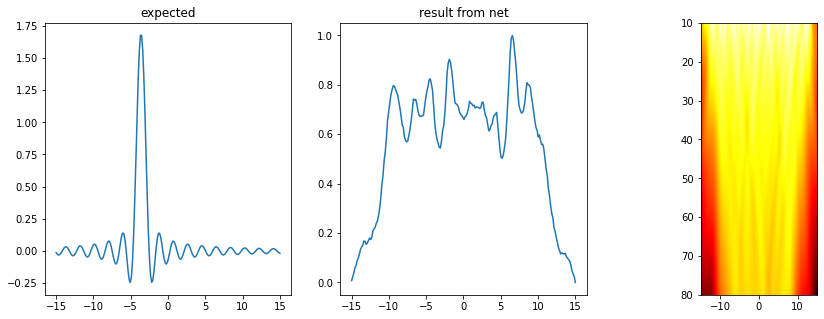

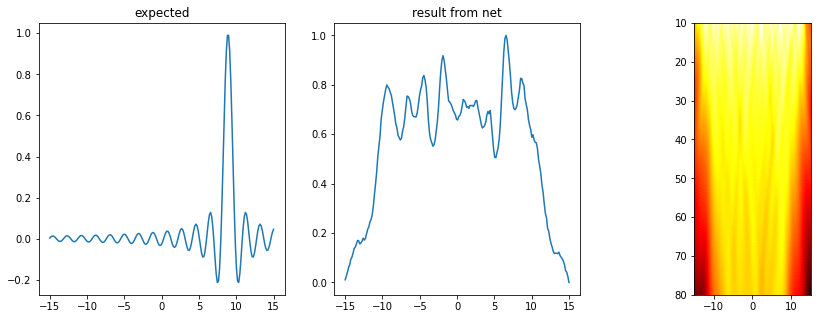

In [ ]:
test_batch_delays(net,dataManager)
test_batch(net,dataManager)




In [ ]:
print(len(dataManager.get_datasets()[0]))



10000


In [ ]:
datasets = dataManager.get_datasets()
train = datasets[0]
x_1,y_1 = train[20]
x_2,y_2 = train[5]
x_1 = x_1.reshape(1,-1,50).float()
x_2 = x_2.reshape(1,-1,50).float()
criterion = nn.MSELoss()
h_1 = net.init_hidden(1)
h_2 = net.init_hidden(1)
print(x_1.size())
print(criterion(x_1,x_2))
print(criterion(net(x_1,h_1)[0],net(x_2,h_2)[0]))
print(criterion(y_1,y_2))



In [ ]:
test_batch(net,dataManager)



In [ ]:
'''
copied from matlab, if want to use need to adjust

def calc_delay(focus,N_elements = 128, c = 1490, pitch = 0.218e-3):
    first = np.norm(focus)
    centers = np.arange(-num_elements/2+1,num_elements/2)
    centers = centers * pitch
    centers = [centers zeros(length(centers),2)];
    second = vecnorm(centers - focus,2,2)
    Delay = (first - second)/c
'''

